# Car Pplate Detector 

> PART 1

<img src="/Users/adrian/Desktop/PY-PROJECTS/Machine_Learning/cart-plate-detector/fonts/img/img1.jpg" style="width:300px;height 300px"/>

### Teaching a NN to "read" symbols from the image
* generate randomized images of different scales using PIL library
* train a network detect each symbol separatly

## Generate an image with a symbol

In [49]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
from matplotlib import pyplot as plt


SIZE = (100,100)
ANGLES = [ -6, -3 , 0, 3, 6]
CHARS = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-. "
CHARS_LEN = len(CHARS)
FONTS = ["arial", "courier", "times"]


def generateCharacter(char, size, color, bgColor, fontName, angle = 0):
    # GENERATE AN IMAGE WITH A SINGLE CHARACTER

    img = Image.new(mode="L", size = size, color = bgColor)
    draw = ImageDraw.Draw(img)

    font = ImageFont.truetype(f"./fonts/{fontName}.ttf", int(size[1] * 0.8))

    draw.text((15,5), char, fill=color, font=font)

    img = img.rotate(angle)

    return img
# img.show()


def charToOneHot(char):
    index = CHARS.index(char)
    length = CHARS_LEN
    one_hot_vector = [0 for _ in range(index)] + [1] + [0 for _ in range(length - index - 1)]
    return one_hot_vector


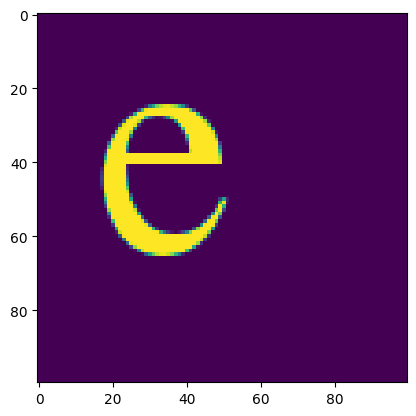

In [51]:
# img1 = generateCharacter("y", SIZE, 255, 0, "courier", 45)

# plt.figure()
# plt.imshow(img1)
# img2 = generateCharacter("y", SIZE, 255, 0, "times")

# plt.figure()
# plt.imshow(img2)

# img3 = generateCharacter("y", SIZE, 255, 0, "arial")

# plt.figure()
# plt.imshow(img3)

# print(charToOneHot("."))
# print(len(charToOneHot(".")))

# CREATE THE DATASET

In [ ]:
import numpy as np

data_x = None
data_y = None

i = 0
for angle in ANGLES:
    for font in FONTS:
        for c in CHARS:
            img = generateCharacter(c, SIZE, 255, 0, font, angle)
            if i == 0:
                data_x = np.array([np.array(img)])
                data_y = np.array([charToOneHot(c)])
            else:    
                data_x = np.append(data_x, [np.array(img)], axis=0)
                data_y = np.append(data_y, [charToOneHot(c)], axis=0)

            i += 1

for i in range(1000):
    img = np.random.rand(100,100)
    data_x = np.append(data_x, [img], axis=0)
    data_y = np.append(data_y, [charToOneHot(" ")], axis=0)

print(f"generated {data_x.shape} matrix with images")    
print(f"generated {data_y.shape} matrix with labels")    
# print(data_y)
# print(data_x)

In [ ]:
plt.imshow(data_x[1100])
print(data_y[1100])

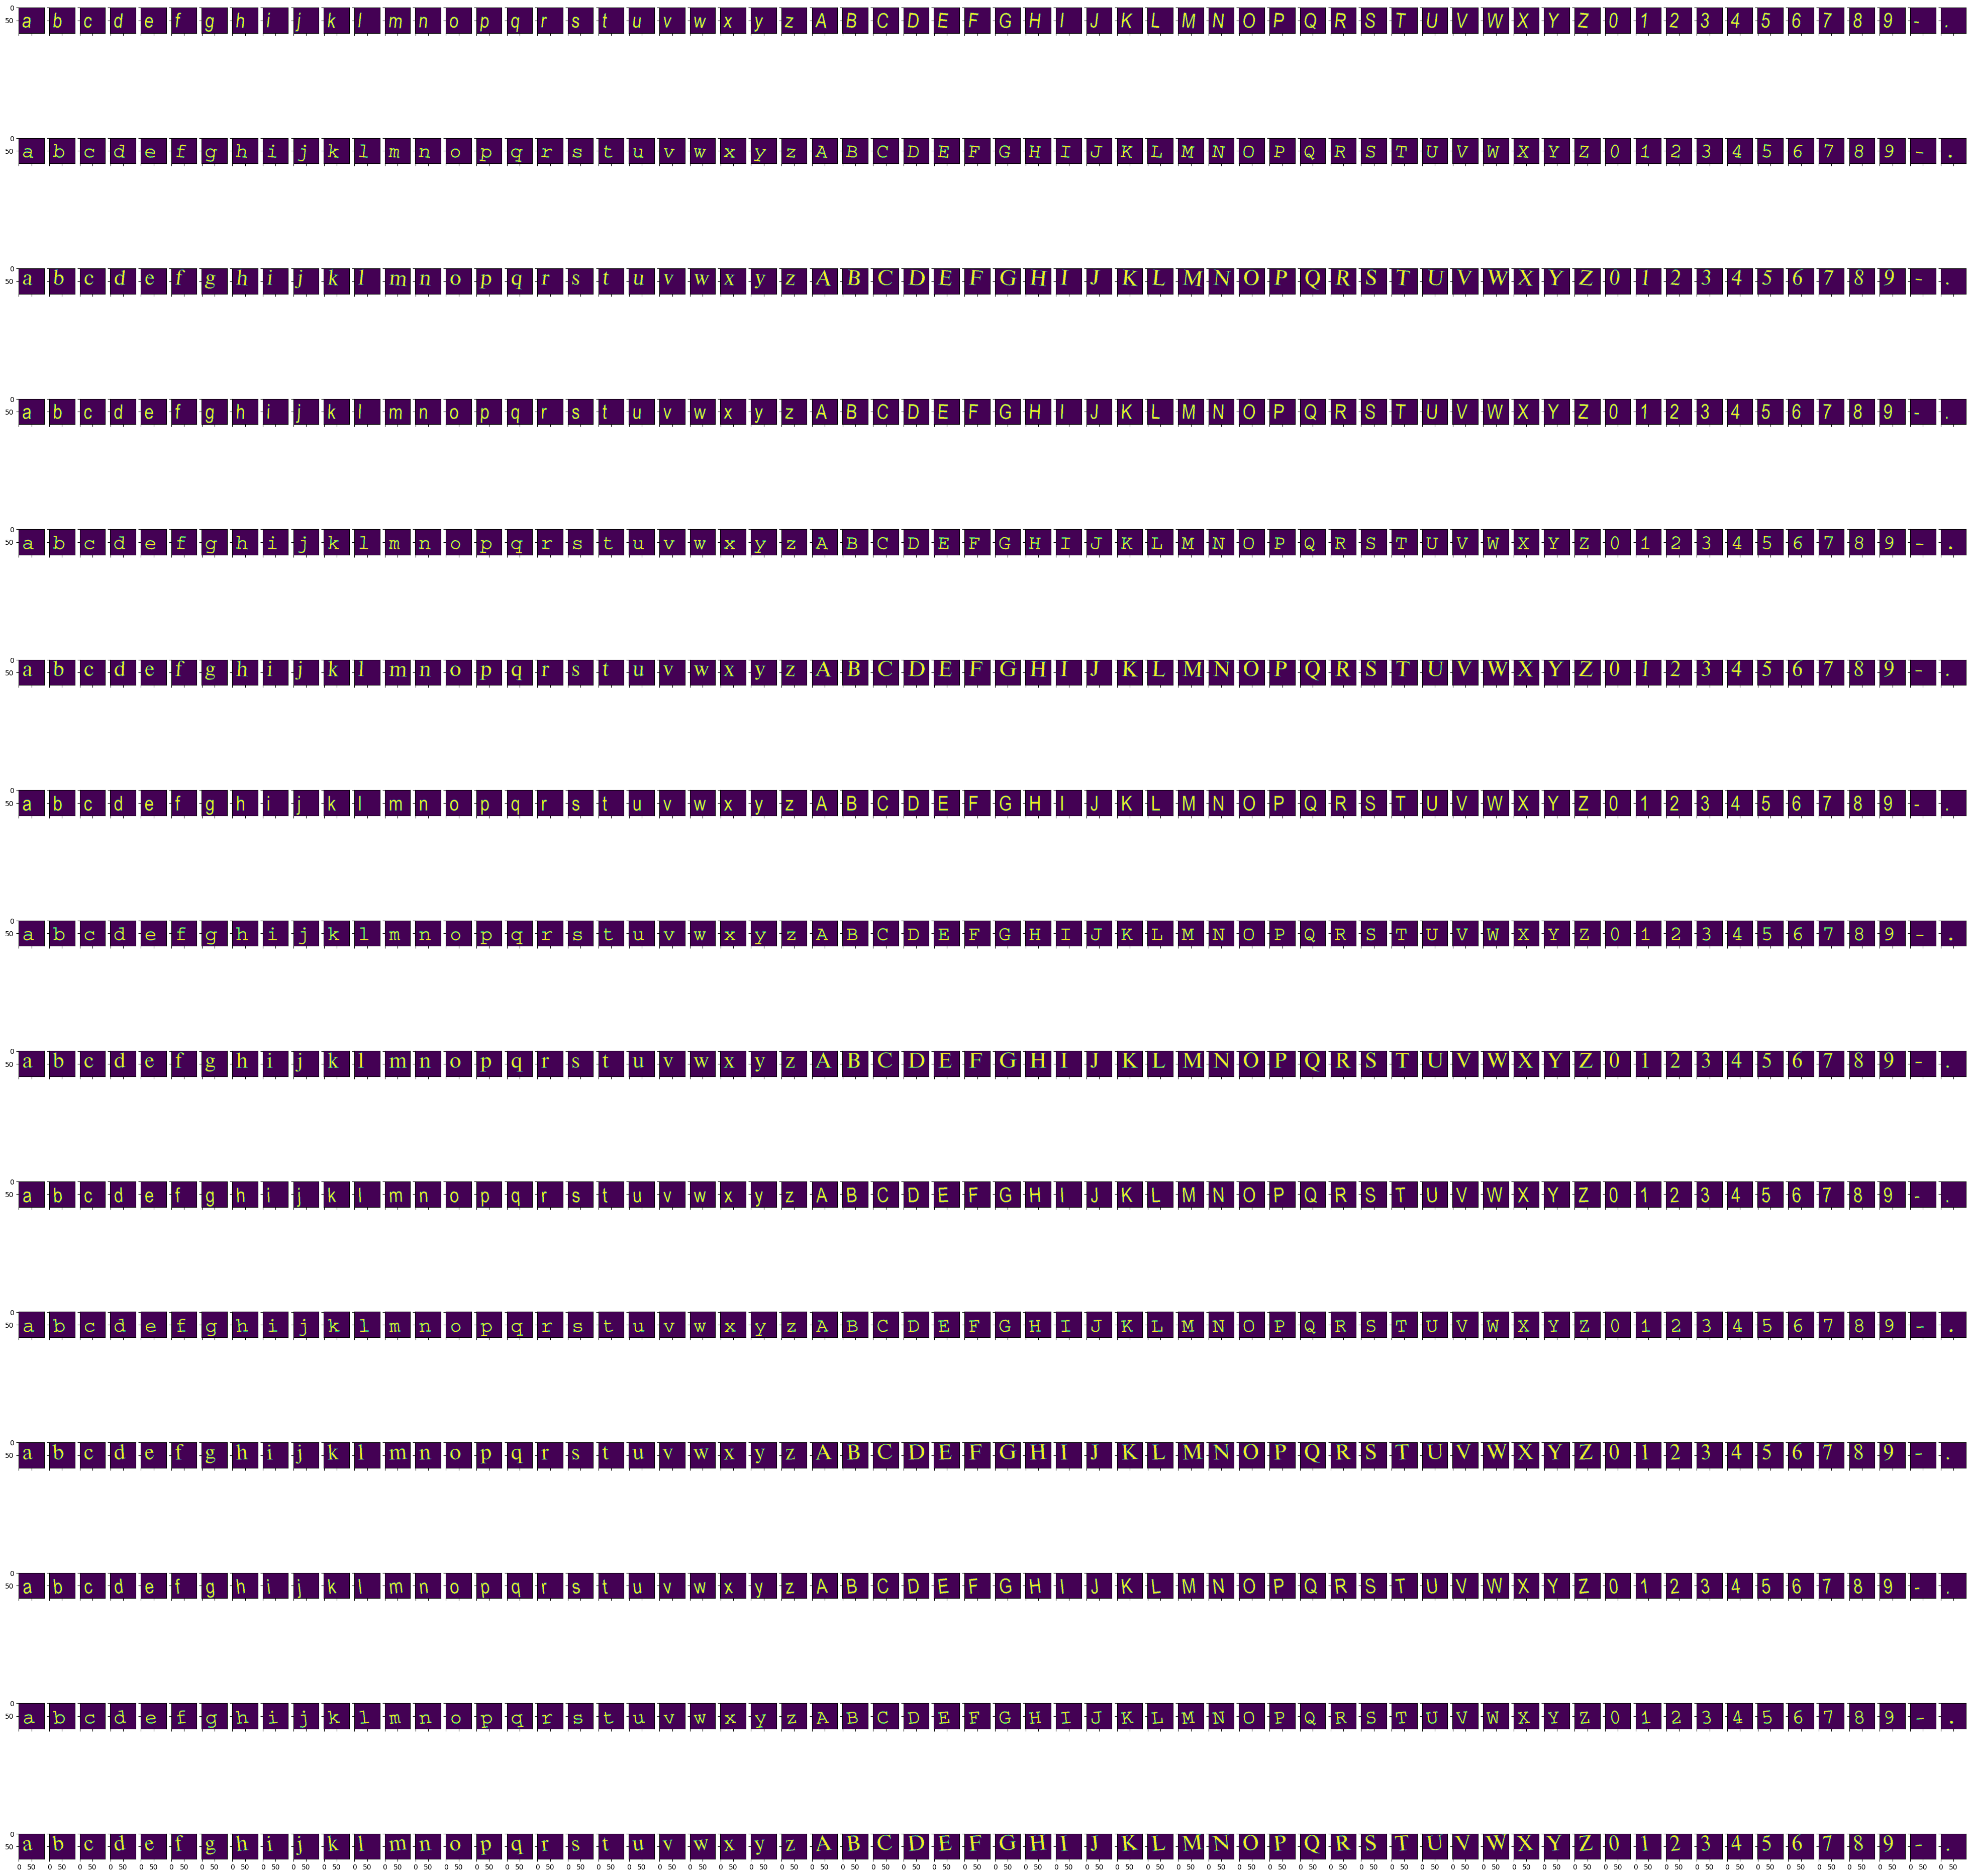

In [53]:
fig = plt.figure(figsize=(50,50))
grid = fig.add_gridspec(15,CHARS_LEN)
axis = grid.subplots(sharex='col', sharey='row')

r = 0
c = 0
for i in range(data_x.shape[0]):

    axis[r,c].imshow(data_x[i])
    c += 1
    if c == CHARS_LEN:
        r += 1
        c = 0

plt.show()
# print(axis)
# for x in data_x:
#     plt.figure(figsize=(1,1))
#     plt.imshow(x)

## One HOT ENCODING

In [46]:
alphabet= ['a','b','c']
# [
#   [1,0,0] -> a
#   [0,1,0] -> b
#   [0,0,1] -> c
# ]

## Create a basic NN

   input 100x100 ---> CNN(64 x 100x100) ---> DNN(64 x 512)---> LLN(512 x 64) ---> output 64     



In [48]:
import torch, torch.nn as nn, torch.optim as optim


model = nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=CHARS_LEN, kernel_size=(100,100)),
    nn.Flatten(start_dim=0),
    nn.Linear(in_features=CHARS_LEN, out_features=512),
    nn.Sigmoid(),
    nn.Linear(in_features=512, out_features=CHARS_LEN),
)

# Pass one sample through the NN

In [ ]:
x = torch.from_numpy(data_x[1]).type(torch.FloatTensor).view(1,100,100)
# plt.imshow(x)
print(x.shape)

y = torch.argmax(model(x))

print(CHARS[y])


# Training loop

In [ ]:
criterion  = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(1,101):
    avg_loss = 0
    print(f"epoch {epoch:5} started ...", end="")
    for i in range(len(data_x)):
        x = torch.from_numpy(data_x[i]).type(torch.FloatTensor).view(1,100,100)
        y = torch.from_numpy(data_y[i]).type(torch.FloatTensor)

        optimizer.zero_grad()
        yp = model(x)
        loss = criterion(yp, y)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    avg_loss /= len(data_x)        
    print(f" finished {avg_loss:f}")    
    # break


# Estimate accuracy

In [ ]:
accuracy = 0
print("estimating accuracy ", end="")
for i in range(len(data_x)):
    x = torch.from_numpy(data_x[i]).type(torch.FloatTensor).view(1,100,100)
    y = torch.from_numpy(data_y[i]).type(torch.FloatTensor)
    yp = model(x)

    if torch.argmax(y) == torch.argmax(yp):
        accuracy += 1


accuracy = 100 * accuracy / len(data_x)

print(f" = {accuracy} %")


# Manual test

In [ ]:
# img = generateCharacter(",", SIZE, 255, 0, "arial", 0)
img = Image.open("images/i1.jpeg")
img = ImageOps.grayscale(img)
img = np.array(img)
img = img[50:150,50:150]
# print(img.shape)
plt.imshow(img)
x = torch.from_numpy( np.array(img) ).type(torch.FloatTensor).view(1,100,100)
y = model(x)
print(f"'{CHARS[torch.argmax(y)]}'")

# Scanning Each 100x100 sector -> building the map

In [ ]:
matrix = []
img = Image.open("Users/adrian/Desktop/PY-PROJECTS/Machine_Learning/cart-plate-detector/fonts/img/img2.jpg")
img = ImageOps.grayscale(img)
img = np.array(img)

for r in range(180):
    row = []
    for c in range(280):

        imgs = img[r*10:r*10+100,c*10:c*10+100]
        # print(img.shape)
        # plt.figure()
        # plt.imshow(imgs)
        x = torch.from_numpy( np.array(imgs) ).type(torch.FloatTensor).view(1,100,100)
        y = model(x)
        c = CHARS[torch.argmax(y)]
        row.append(c)
        if c != ' ':
            print(c)
    matrix.append(row)    

print(matrix)